In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

In [6]:
# Step 1: Load Datasets
# Assuming we have 4 datasets: 'movies.csv', 'ratings.csv', 'tags.csv', 'links.csv'
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')

In [15]:
ratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [16]:
movies

,movieId,title,genres,tag,content
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,Adventure|Animation|Children|Comedy|Fantasy pi...
1,2,Jumanji (1995),Adventure|Children|Fantasy,fantasy magic board game Robin Williams game,Adventure|Children|Fantasy fantasy magic board...
2,3,Grumpier Old Men (1995),Comedy|Romance,moldy old,Comedy|Romance moldy old
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,,Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,Comedy pregnancy remake
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,,Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,,Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama,,Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,,Action|Animation


In [17]:
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [18]:
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


In [23]:
# Step 2: Data Preprocessing and Cleaning
# Merge movie tags into the movies DataFrame
tags['tag'] = tags['tag'].fillna('')
movies_tags = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
movies = pd.merge(movies, movies_tags, on='movieId', how='left')
movies['tag'] = movies['tag'].fillna('')

# Remove unnecessary columns and handle missing values
movies = movies[['movieId', 'title', 'genres', 'tag']]
ratings = ratings[['userId', 'movieId', 'rating']]


movieId    0
title      0
genres     0
tag        0
dtype: int64
userId     0
movieId    0
rating     0
dtype: int64


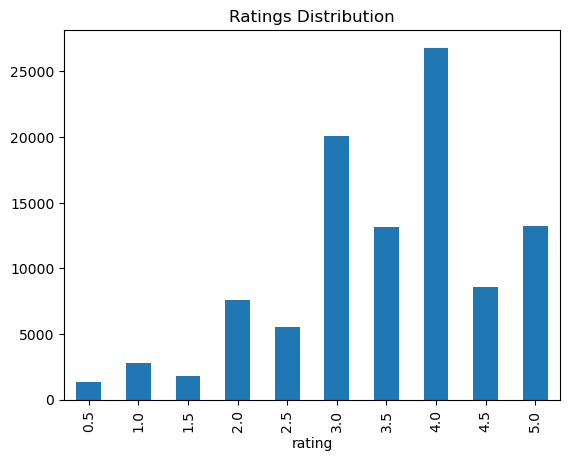

In [8]:
# Step 3: Exploratory Data Analysis (EDA)
# Check for missing values
print(movies.isnull().sum())
print(ratings.isnull().sum())

# Plot some basic statistics
ratings.groupby('rating').size().plot(kind='bar', title="Ratings Distribution")
plt.show()

In [9]:
# Step 4: Building Content-Based Filtering Model
# Combine genres and tags to create a content-based feature
movies['content'] = movies['genres'] + ' ' + movies['tag']

# Use TF-IDF vectorizer to convert the content into a numerical vector
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['content'])

# Compute cosine similarity between movie content
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Content-Based Recommendation Function
def content_recommendations(movie_id, num_recommendations=5):
    idx = movies[movies['movieId'] == movie_id].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_recommendations + 1]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]

# Test Content-Based Recommendation
print("Content-Based Recommendations for Movie ID 1:")
print(content_recommendations(1))


Content-Based Recommendations for Movie ID 1:
1757                              Bug's Life, A (1998)
2355                                Toy Story 2 (1999)
8695                  Guardians of the Galaxy 2 (2017)
1706                                       Antz (1998)
2809    Adventures of Rocky and Bullwinkle, The (2000)
Name: title, dtype: object


In [19]:
movies['content']

0       Adventure|Animation|Children|Comedy|Fantasy pi...
1       Adventure|Children|Fantasy fantasy magic board...
2                                Comedy|Romance moldy old
3                                   Comedy|Drama|Romance 
4                                 Comedy pregnancy remake
                              ...                        
9737                     Action|Animation|Comedy|Fantasy 
9738                            Animation|Comedy|Fantasy 
9739                                               Drama 
9740                                    Action|Animation 
9741                                              Comedy 
Name: content, Length: 9742, dtype: object

In [12]:
# Step 5: Building Collaborative Filtering Model
# Create user-item ratings matrix
user_movie_ratings = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
matrix = csr_matrix(user_movie_ratings.values)

# Apply Singular Value Decomposition (SVD) to reduce dimensionality
svd = TruncatedSVD(n_components=20, random_state=42)
matrix_svd = svd.fit_transform(matrix)

# Compute similarity based on SVD features
movie_similarity = cosine_similarity(matrix_svd.T)

# Collaborative Filtering Recommendation Function
def collaborative_recommendations(user_id, num_recommendations=5):
    user_index = user_id - 1  # User IDs start at 1, index starts at 0
    scores = list(enumerate(matrix_svd[user_index]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    movie_indices = [i[0] for i in scores[:num_recommendations]]
    return movies['title'].iloc[movie_indices]

# Test Collaborative Filtering Recommendation
print("\nCollaborative Filtering Recommendations for User ID 1:")
print(collaborative_recommendations(1))



Collaborative Filtering Recommendations for User ID 1:
0                          Toy Story (1995)
14                  Cutthroat Island (1995)
10           American President, The (1995)
18    Ace Ventura: When Nature Calls (1995)
15                            Casino (1995)
Name: title, dtype: object


In [13]:
# Step 6: Hybrid Recommendation System (Combining Content-Based and Collaborative)
def hybrid_recommendations(user_id, movie_id, num_recommendations=5):
    # Get content-based recommendations
    content_based_recs = content_recommendations(movie_id, num_recommendations=num_recommendations*2)
    
    # Get collaborative recommendations for the user
    collaborative_recs = collaborative_recommendations(user_id, num_recommendations=num_recommendations*2)
    
    # Combine the recommendations, giving priority to collaborative filtering
    combined_recs = pd.concat([collaborative_recs, content_based_recs]).drop_duplicates().head(num_recommendations)
    return combined_recs

# Test Hybrid Recommendation System
print("\nHybrid Recommendations for User ID 1 and Movie ID 1:")
print(hybrid_recommendations(1, 1))


Hybrid Recommendations for User ID 1 and Movie ID 1:
0                          Toy Story (1995)
14                  Cutthroat Island (1995)
10           American President, The (1995)
18    Ace Ventura: When Nature Calls (1995)
15                            Casino (1995)
Name: title, dtype: object


In [14]:
# Step 7: Evaluation
# Evaluate Content-Based Recommendations
content_recs = content_recommendations(1)
print("\nContent-Based Evaluation:")
print(content_recs)

# Evaluate Collaborative Filtering Recommendations
collaborative_recs = collaborative_recommendations(1)
print("\nCollaborative Filtering Evaluation:")
print(collaborative_recs)

# Evaluate Hybrid Recommendations
hybrid_recs = hybrid_recommendations(1, 1)
print("\nHybrid Evaluation:")
print(hybrid_recs)



Content-Based Evaluation:
1757                              Bug's Life, A (1998)
2355                                Toy Story 2 (1999)
8695                  Guardians of the Galaxy 2 (2017)
1706                                       Antz (1998)
2809    Adventures of Rocky and Bullwinkle, The (2000)
Name: title, dtype: object

Collaborative Filtering Evaluation:
0                          Toy Story (1995)
14                  Cutthroat Island (1995)
10           American President, The (1995)
18    Ace Ventura: When Nature Calls (1995)
15                            Casino (1995)
Name: title, dtype: object

Hybrid Evaluation:
0                          Toy Story (1995)
14                  Cutthroat Island (1995)
10           American President, The (1995)
18    Ace Ventura: When Nature Calls (1995)
15                            Casino (1995)
Name: title, dtype: object
